<h1>This notebook will be used for all the EDA of our cleaned databases.</h1>

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
mdm = pd.read_csv("../data/mdm_clean.csv")
comp_dim = pd.read_csv("../data/comp_dim_clean.csv")
investments = pd.read_csv("../data/mintic_investments_clean.csv")

In [35]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_style('darkgrid')

In [4]:
mdm.codigo = mdm.codigo.astype('category')
mdm.id = mdm.id.astype('category')
mdm.grupo_dotaciones = mdm.grupo_dotaciones.astype('category')
mdm.grupo_dotaciones.cat.categories =  ['c', 'g1', 'g2', 'g3', 'g4', 'g5']

In [5]:
name_cols = {'codigo': 'codigo_municipio',
             'departame_nombre': 'departamento',
             'departame_cod': 'codigo_departamento',
             'municipio_nombre': 'municipio',
             'municipio_cod': 'codigo_municipio'}

mdm.rename(name_cols, axis = 1, inplace = True)
comp_dim.rename(name_cols, axis = 1, inplace = True)
investments.rename(name_cols, axis = 1, inplace = True)

In [6]:
mdm.head(1)

,anio_corte,municipio,codigo_municipio,departamento,grupo_dotaciones,categoria_de_ruralidad,mdm,puesto_mdm_grupo_dotaciones,puesto_mdm_nacional,id
0,2016,medellin,5001,antioquia,c,ciudades_y_aglomeraciones,80.78,1,3,20165001


In [7]:
mdm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4404 entries, 0 to 4403
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   anio_corte                   4404 non-null   int64   
 1   municipio                    4404 non-null   object  
 2   codigo_municipio             4404 non-null   category
 3   departamento                 4404 non-null   object  
 4   grupo_dotaciones             4404 non-null   category
 5   categoria_de_ruralidad       4404 non-null   object  
 6   mdm                          4404 non-null   float64 
 7   puesto_mdm_grupo_dotaciones  4404 non-null   int64   
 8   puesto_mdm_nacional          4404 non-null   int64   
 9   id                           4404 non-null   category
dtypes: category(3), float64(1), int64(3), object(3)
memory usage: 467.0+ KB


In [8]:
comp_dim.head(1)

,anio_corte,municipio,codigo_municipio,departamento,grupo_dotaciones,categoria_de_ruralidad,cobertura_media_neta,saber_11_matematicas,saber_11_lenguaje,cobertura_transicion,cobertura_salud,vacunacion_pentavalente,mortalidad_infantil,cobertura_electrica_rural,cobertura_internet,cobertura_acueducto,cobertura_alcantarillado,hurtos,hurtos_x_10000_hab,homicidios,homicidios_x_10000_hab,violencia_intrafamiliar,violencia_intrafamiliar_x_10000_hab,id
0,2016,medellin,5001,antioquia,c,ciudades_y_aglomeraciones,0.559,49.26,51.7,0.737,1.0,0.971,11.12,1.0,0.214,0.97,0.92,13871,55.78,536,2.16,2374,9.55,20165001


In [9]:
comp_dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4404 entries, 0 to 4403
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   anio_corte                           4404 non-null   int64  
 1   municipio                            4404 non-null   object 
 2   codigo_municipio                     4404 non-null   int64  
 3   departamento                         4404 non-null   object 
 4   grupo_dotaciones                     4404 non-null   object 
 5   categoria_de_ruralidad               4404 non-null   object 
 6   cobertura_media_neta                 4404 non-null   float64
 7   saber_11_matematicas                 4404 non-null   float64
 8   saber_11_lenguaje                    4404 non-null   float64
 9   cobertura_transicion                 4404 non-null   float64
 10  cobertura_salud                      4404 non-null   float64
 11  vacunacion_pentavalente       

In [10]:
investments.head(1)

,anio_corte,fecha_corte,departamento,codigo_departamento,municipio,codigo_municipio,iniciativa,viceministerio,indicador,descripcion_indicador,inversion,beneficiarios,id
0,2020,2020-12-31,bogota,11,bogota_d.c.,11001,asesorias_en_teletrabajo,transformacion,numero_de_personas_impactadas_con_la_difusion_...,numero_de_personas_impactadas_con_la_difusion_...,773577049710,606,202011001


In [11]:
investments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63361 entries, 0 to 63360
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   anio_corte             63361 non-null  int64 
 1   fecha_corte            63361 non-null  object
 2   departamento           63361 non-null  object
 3   codigo_departamento    63361 non-null  object
 4   municipio              63361 non-null  object
 5   codigo_municipio       63361 non-null  int64 
 6   iniciativa             63361 non-null  object
 7   viceministerio         63361 non-null  object
 8   indicador              63361 non-null  object
 9   descripcion_indicador  63361 non-null  object
 10  inversion              63361 non-null  int64 
 11  beneficiarios          63361 non-null  int64 
 12  id                     63361 non-null  int64 
dtypes: int64(5), object(8)
memory usage: 6.3+ MB


In [12]:
mun_mdm = mdm.codigo_municipio.unique()
mun_inv = investments.codigo_municipio.unique()
mun_common = set(mun_mdm).intersection(mun_inv)
anio_mdm = mdm.anio_corte.unique()

In [13]:
investments_clean = investments.loc[investments.codigo_municipio.isin(mun_common)
                                    & investments.anio_corte.isin(anio_mdm)]
investments_clean = investments_clean.groupby(['anio_corte', 'codigo_municipio']).sum().reset_index()

In [14]:
investments_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4404 entries, 0 to 4403
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   anio_corte        4404 non-null   int64
 1   codigo_municipio  4404 non-null   int64
 2   inversion         4404 non-null   int64
 3   beneficiarios     4404 non-null   int64
 4   id                4404 non-null   int64
dtypes: int64(5)
memory usage: 172.2 KB


In [15]:
merge1 = comp_dim.merge(mdm, 
                        on = ['anio_corte', 'codigo_municipio'],
                        suffixes = ['', '_del'])
to_del = merge1.columns[merge1.columns.str.contains('_del')]
merge1.drop(to_del, axis = 1, inplace = True)
merge1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4404 entries, 0 to 4403
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   anio_corte                           4404 non-null   int64  
 1   municipio                            4404 non-null   object 
 2   codigo_municipio                     4404 non-null   object 
 3   departamento                         4404 non-null   object 
 4   grupo_dotaciones                     4404 non-null   object 
 5   categoria_de_ruralidad               4404 non-null   object 
 6   cobertura_media_neta                 4404 non-null   float64
 7   saber_11_matematicas                 4404 non-null   float64
 8   saber_11_lenguaje                    4404 non-null   float64
 9   cobertura_transicion                 4404 non-null   float64
 10  cobertura_salud                      4404 non-null   float64
 11  vacunacion_pentavalente       

In [16]:
merge2 = merge1.merge(investments_clean, 
                      on = ['anio_corte', 'codigo_municipio'],
                      suffixes = ['', '_del'])
to_del = merge2.columns[merge2.columns.str.contains('_del')]
merge2.drop(to_del, axis = 1, inplace = True)
merge2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4404 entries, 0 to 4403
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   anio_corte                           4404 non-null   int64  
 1   municipio                            4404 non-null   object 
 2   codigo_municipio                     4404 non-null   object 
 3   departamento                         4404 non-null   object 
 4   grupo_dotaciones                     4404 non-null   object 
 5   categoria_de_ruralidad               4404 non-null   object 
 6   cobertura_media_neta                 4404 non-null   float64
 7   saber_11_matematicas                 4404 non-null   float64
 8   saber_11_lenguaje                    4404 non-null   float64
 9   cobertura_transicion                 4404 non-null   float64
 10  cobertura_salud                      4404 non-null   float64
 11  vacunacion_pentavalente       

In [17]:
merge2.id = merge2.id.astype('category')
merge2.anio_corte = merge2.anio_corte.astype('category')

In [18]:
merge2.describe()

,cobertura_media_neta,saber_11_matematicas,saber_11_lenguaje,cobertura_transicion,cobertura_salud,vacunacion_pentavalente,mortalidad_infantil,cobertura_electrica_rural,cobertura_internet,cobertura_acueducto,cobertura_alcantarillado,hurtos,hurtos_x_10000_hab,homicidios,homicidios_x_10000_hab,violencia_intrafamiliar,violencia_intrafamiliar_x_10000_hab,mdm,puesto_mdm_grupo_dotaciones,puesto_mdm_nacional,inversion,beneficiarios
count,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4398.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000,4.404000e+03,4404.000000
mean,0.407100,47.950800,49.880186,0.535216,0.808769,0.910899,18.863228,0.879465,0.101718,0.571314,0.388369,254.149637,17.872695,11.413261,2.480690,80.103315,10.004996,50.372279,108.092643,551.000000,5.508837e+08,3757.497956
std,0.156045,4.823078,3.592606,0.164099,0.160228,0.137858,9.315656,0.188705,0.193781,0.298542,0.281378,3363.223109,21.107681,57.512463,3.171105,934.408670,10.011659,10.170328,63.422778,317.867283,3.076640e+09,20395.922893
min,0.013100,0.000000,0.000000,0.051000,0.170000,0.157000,1.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.033311,1.000000,1.000000,0.000000e+00,0.000000
25%,0.307000,44.750000,47.703000,0.423000,0.710000,0.846000,13.510000,0.860000,0.012000,0.340000,0.160000,4.000000,4.460000,0.000000,0.000000,3.000000,3.110000,43.950000,53.000000,276.000000,2.666648e+06,25.000000
50%,0.404900,48.195500,50.129000,0.532050,0.828000,0.938000,17.160000,0.960000,0.030000,0.570000,0.340000,12.000000,10.560000,2.000000,1.590000,9.000000,7.270000,50.209631,108.000000,551.000000,5.223516e+07,174.500000
75%,0.497000,51.356250,52.351750,0.637000,0.945000,1.000000,21.914000,0.990000,0.097250,0.832000,0.580000,44.000000,22.990000,7.250000,3.273055,23.000000,13.545086,56.550113,163.000000,826.000000,1.938855e+08,881.000000
max,1.000000,66.130000,64.130000,1.000000,1.000000,3.394000,87.910000,1.000000,1.000000,1.000000,1.000000,156435.000000,206.028787,1288.000000,31.630000,36179.000000,116.500000,86.816932,218.000000,1101.000000,7.094560e+10,588000.000000


In [19]:
merge3 = merge2.drop(['puesto_mdm_grupo_dotaciones', 'id', 'puesto_mdm_nacional', 'beneficiarios'], axis = 1)

In [20]:
merge3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4404 entries, 0 to 4403
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   anio_corte                           4404 non-null   category
 1   municipio                            4404 non-null   object  
 2   codigo_municipio                     4404 non-null   object  
 3   departamento                         4404 non-null   object  
 4   grupo_dotaciones                     4404 non-null   object  
 5   categoria_de_ruralidad               4404 non-null   object  
 6   cobertura_media_neta                 4404 non-null   float64 
 7   saber_11_matematicas                 4404 non-null   float64 
 8   saber_11_lenguaje                    4404 non-null   float64 
 9   cobertura_transicion                 4404 non-null   float64 
 10  cobertura_salud                      4404 non-null   float64 
 11  vacunacion_pentav

In [27]:
corr = merge3.corr()

<AxesSubplot:>

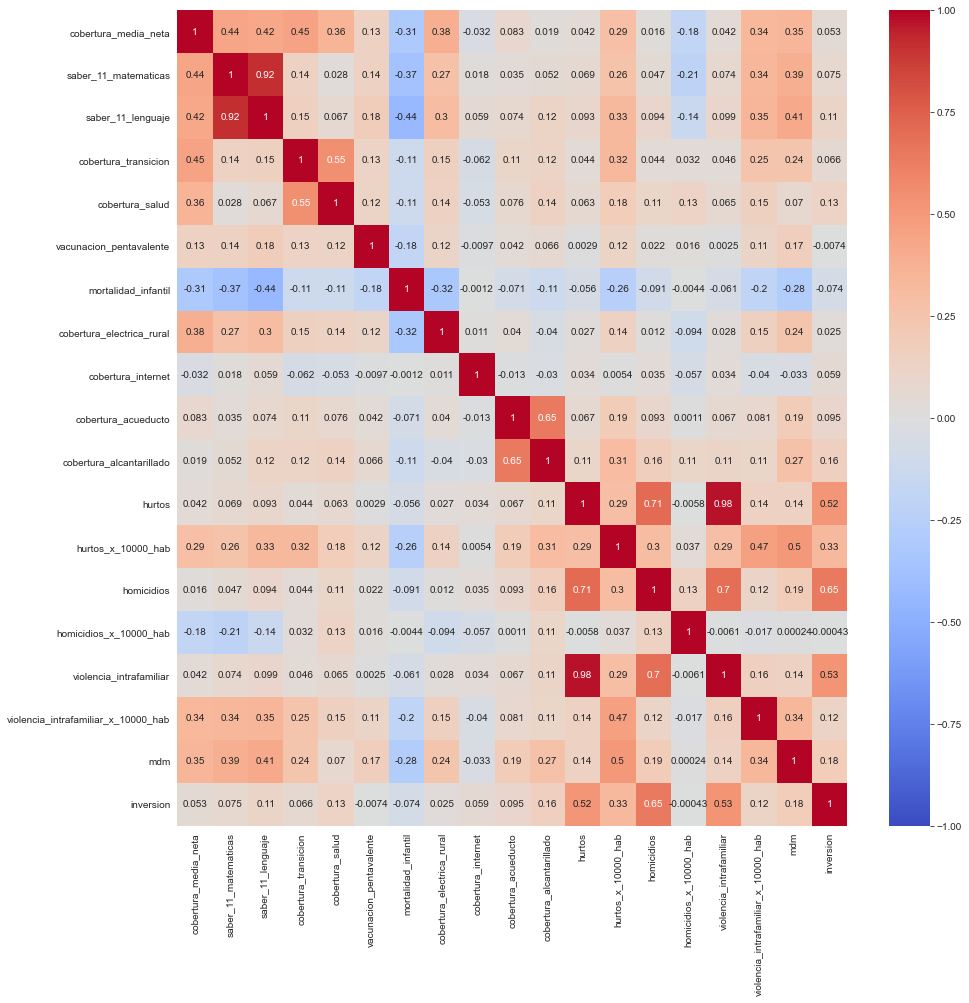

In [42]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)

In [53]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = merge3.select_dtypes(include=numerics).columns
num_cols

Index(['cobertura_media_neta', 'saber_11_matematicas', 'saber_11_lenguaje',
       'cobertura_transicion', 'cobertura_salud', 'vacunacion_pentavalente',
       'mortalidad_infantil', 'cobertura_electrica_rural',
       'cobertura_internet', 'cobertura_acueducto', 'cobertura_alcantarillado',
       'hurtos', 'hurtos_x_10000_hab', 'homicidios', 'homicidios_x_10000_hab',
       'violencia_intrafamiliar', 'violencia_intrafamiliar_x_10000_hab', 'mdm',
       'inversion'],
      dtype='object')

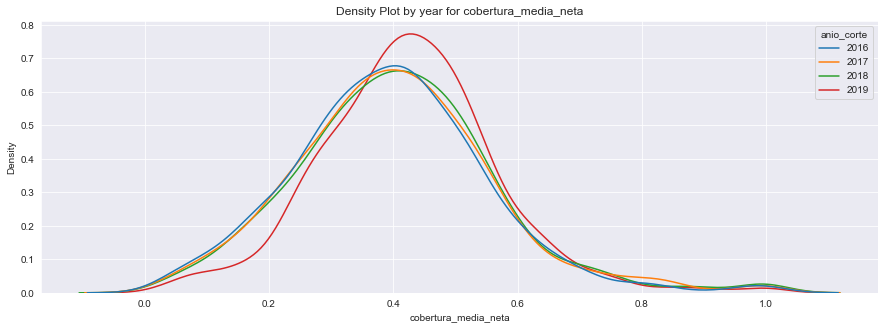

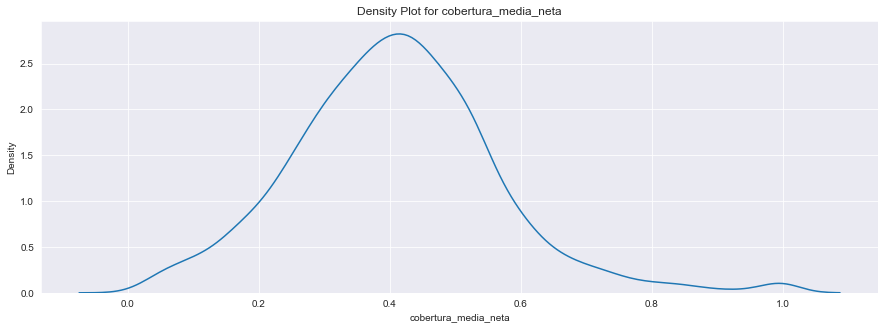

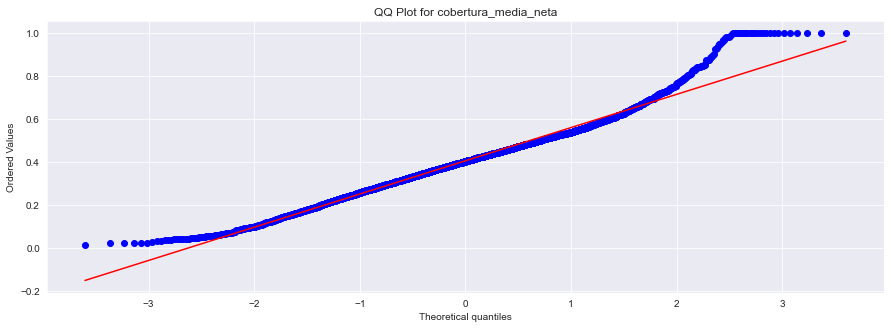

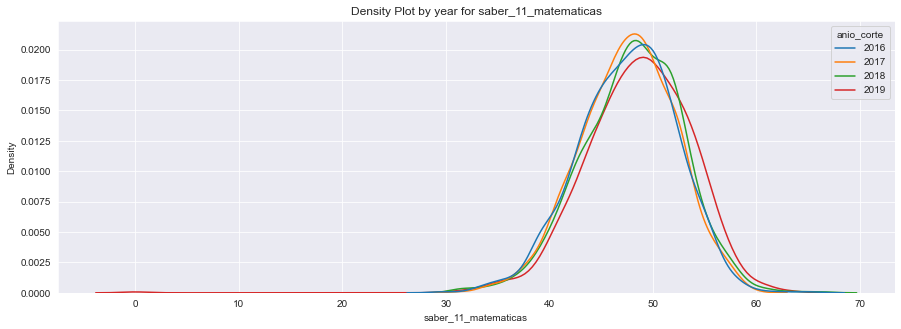

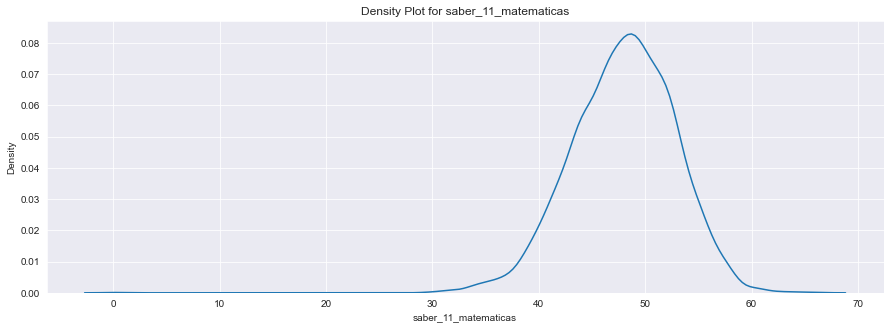

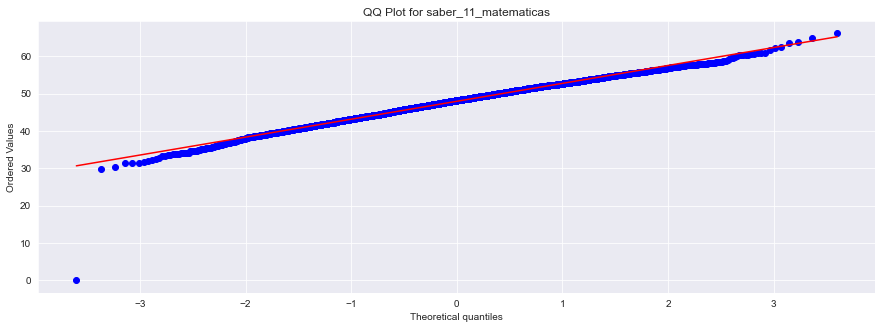

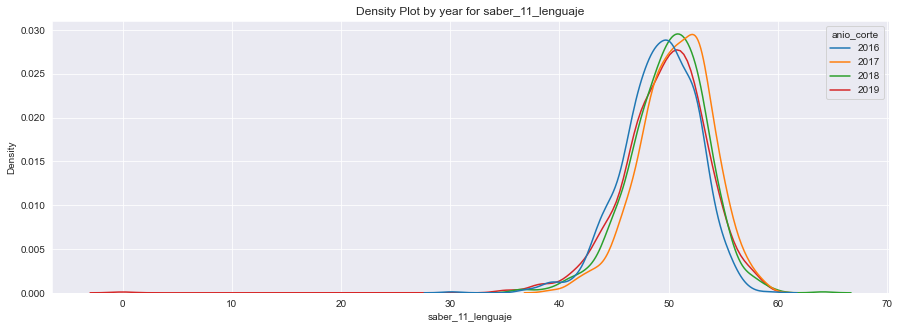

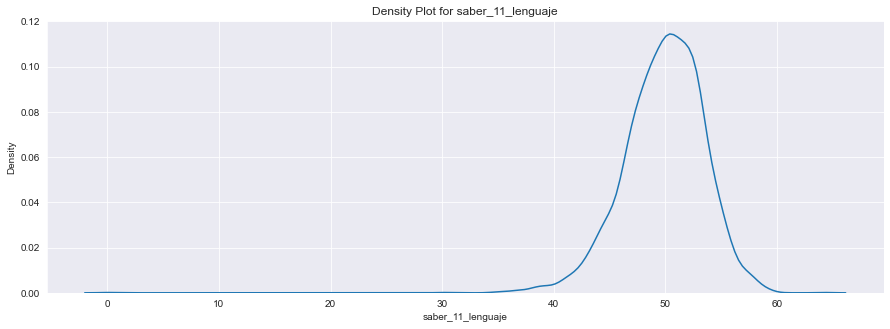

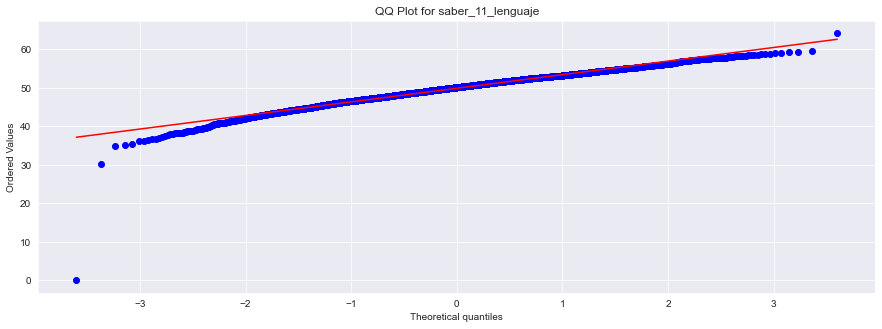

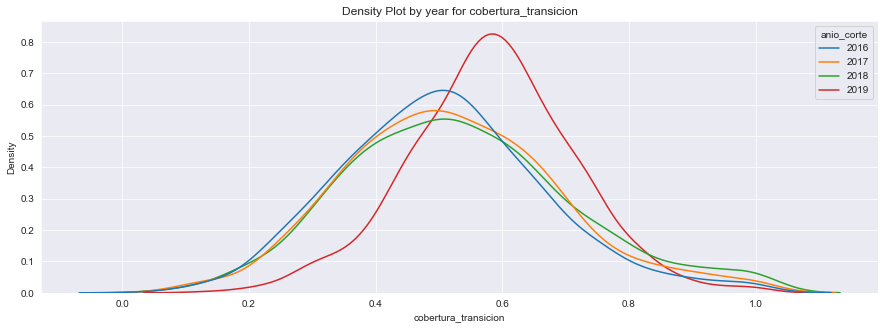

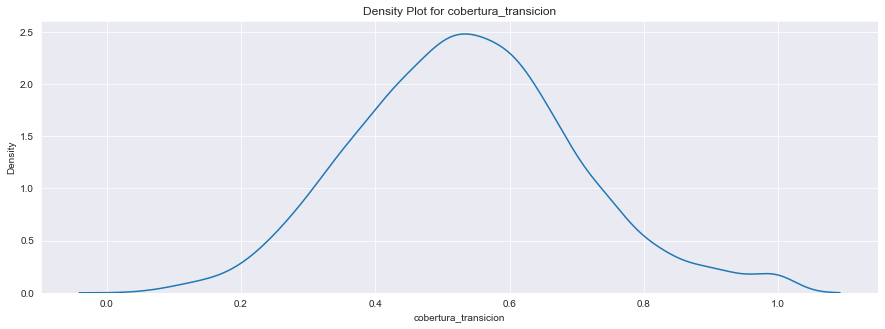

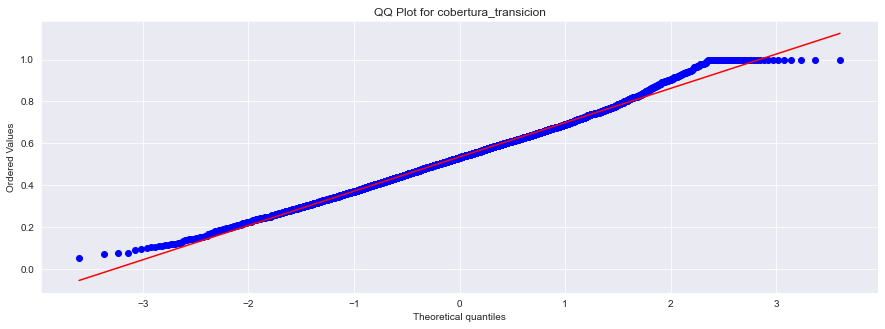

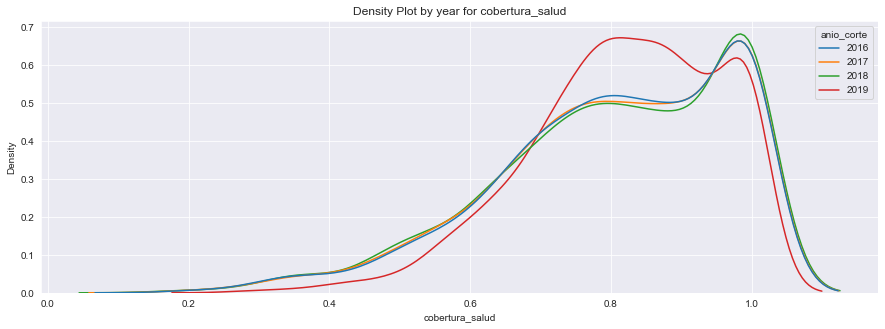

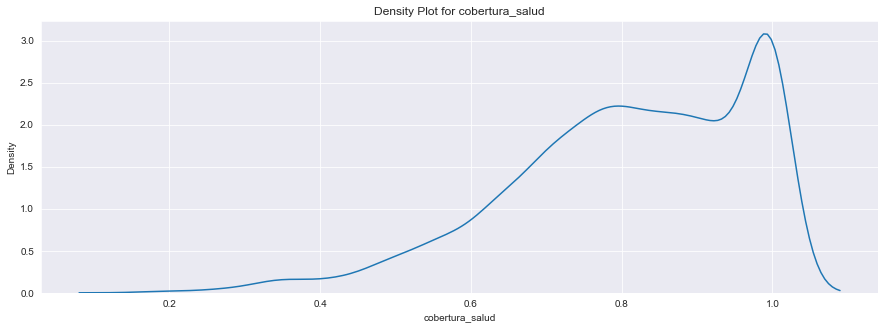

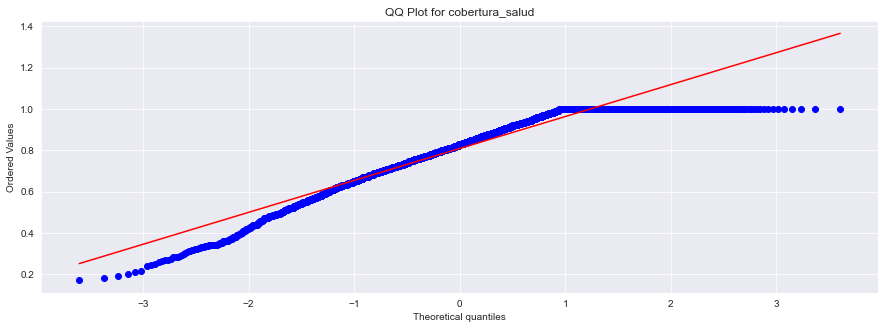

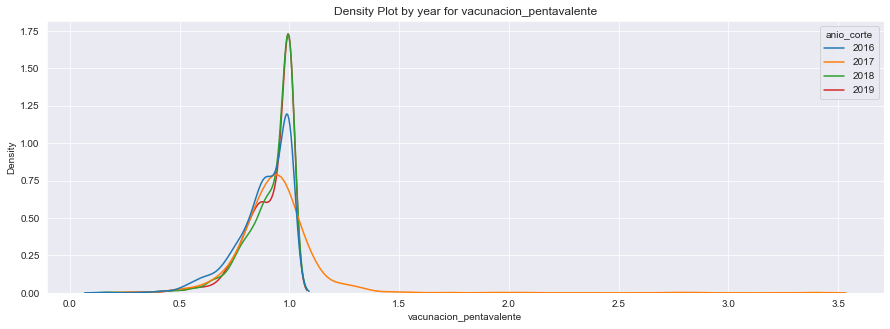

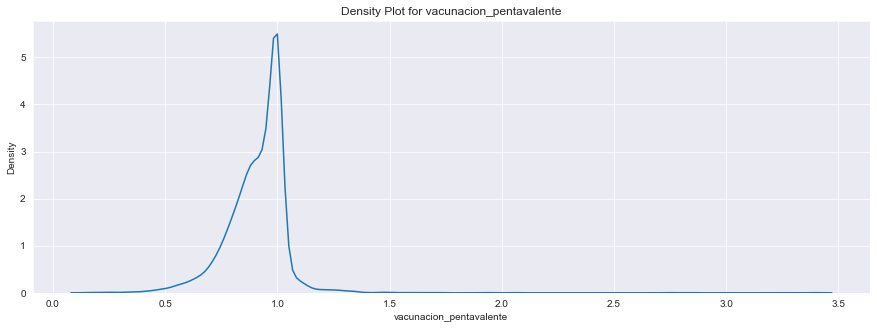

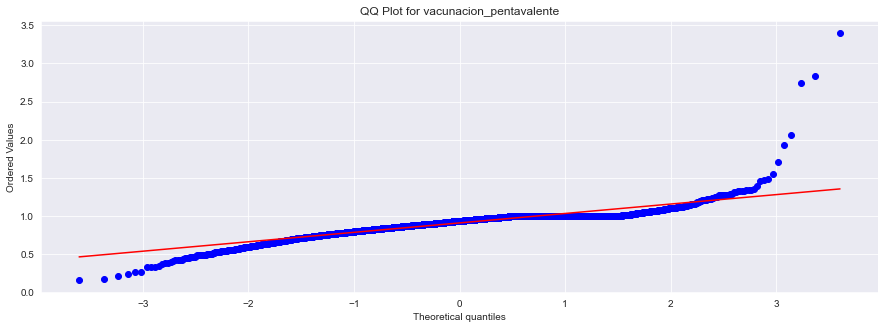

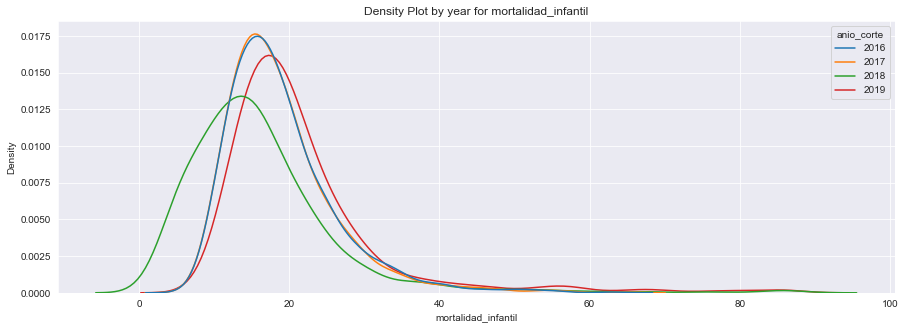

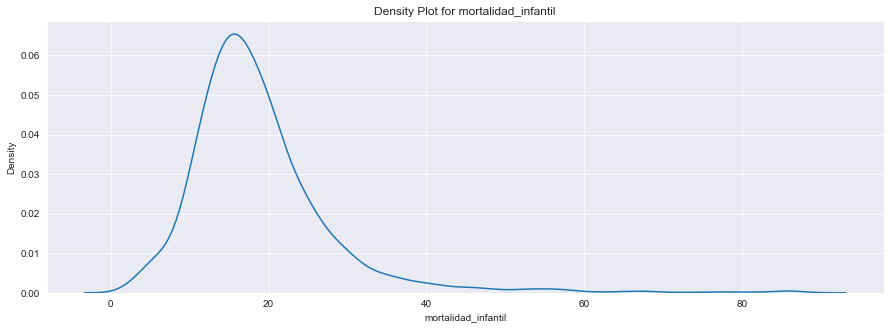

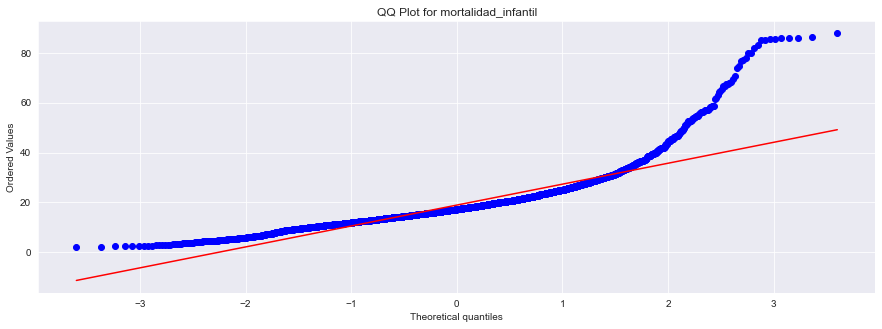

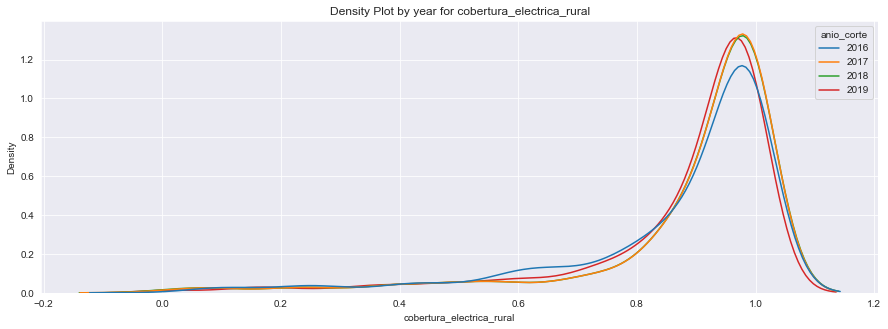

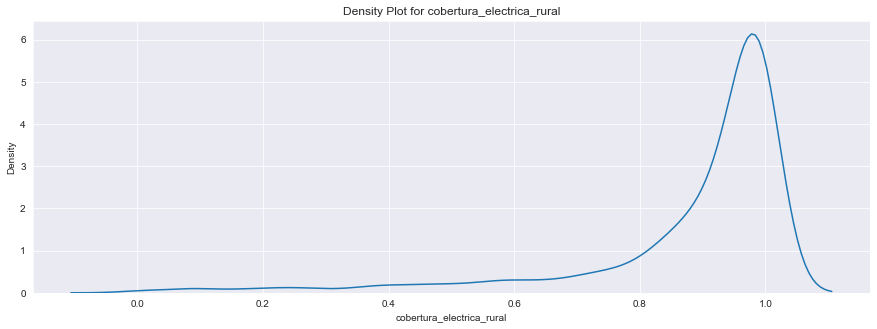

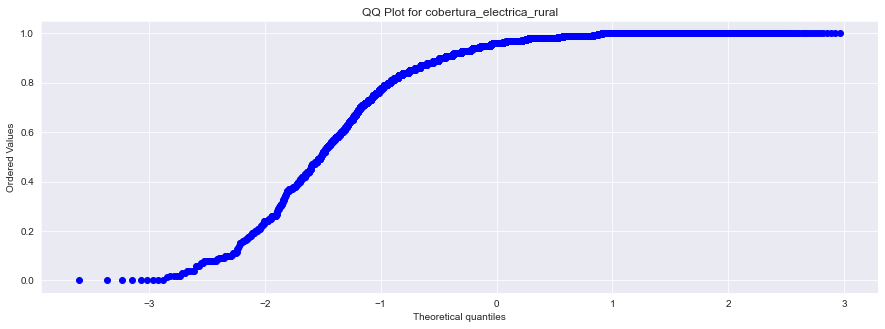

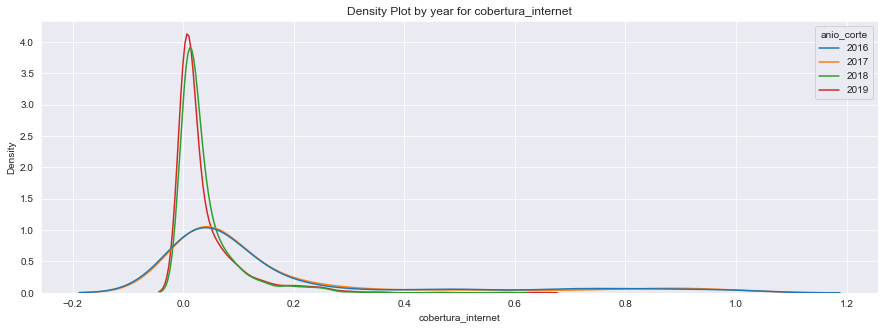

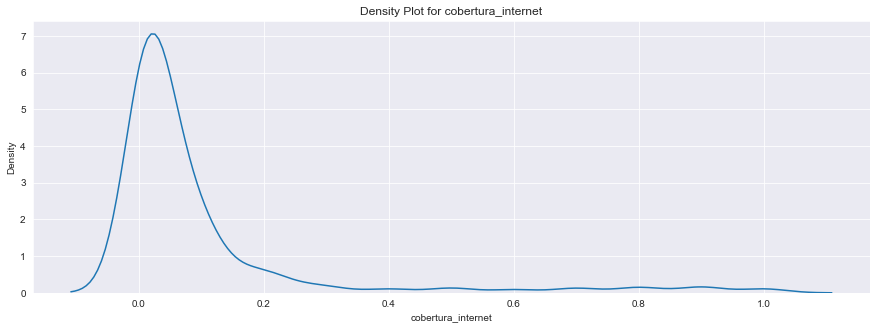

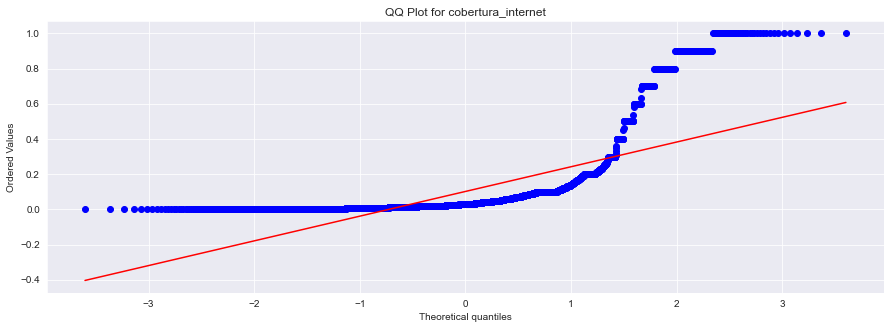

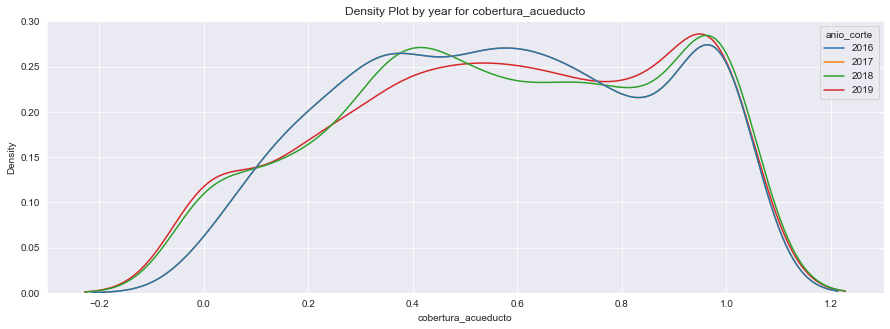

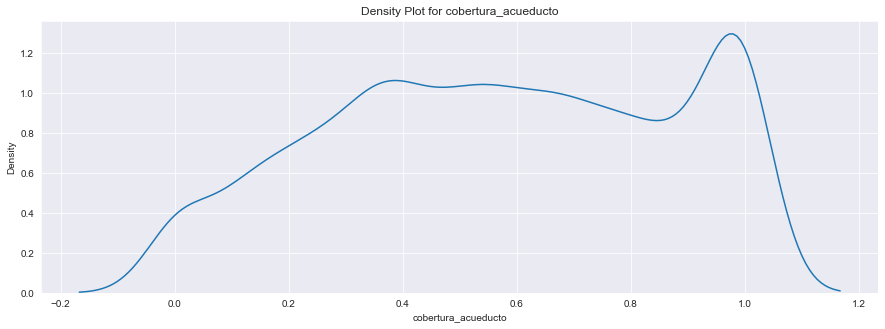

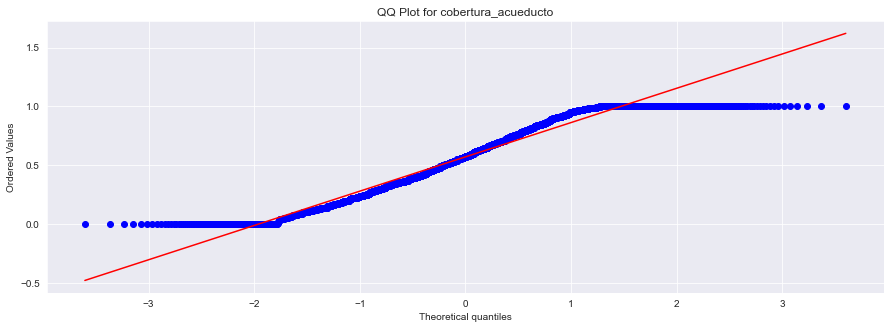

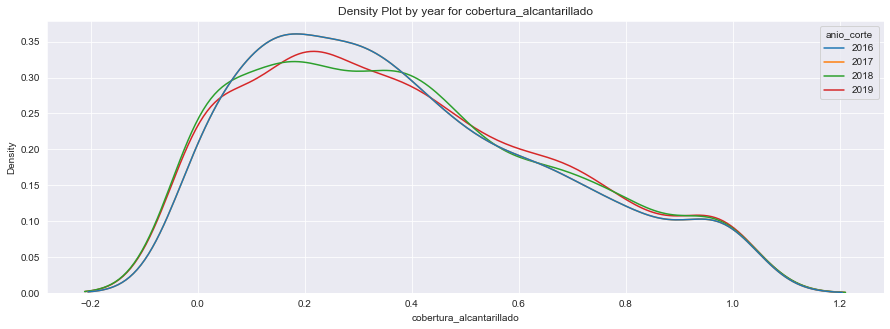

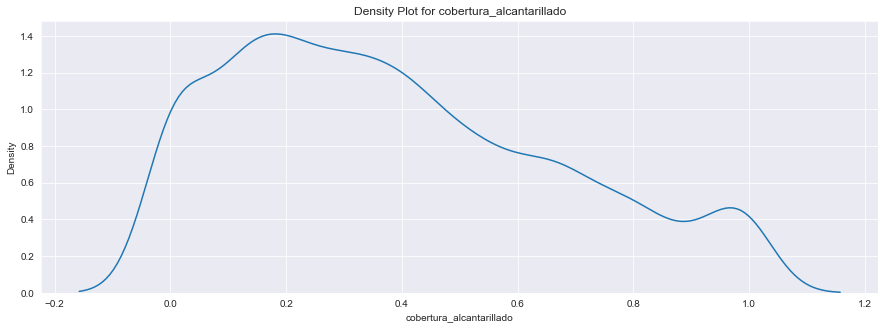

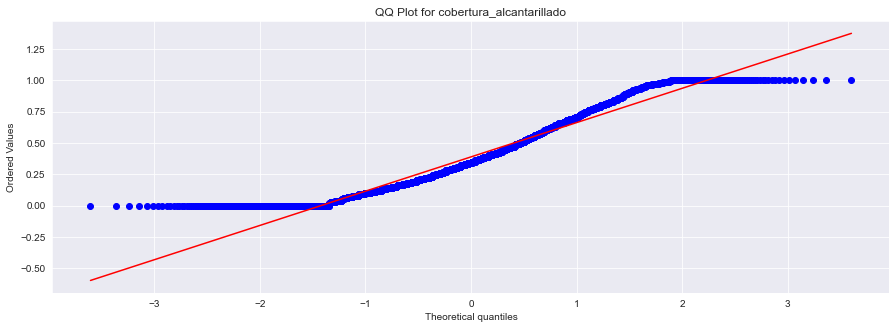

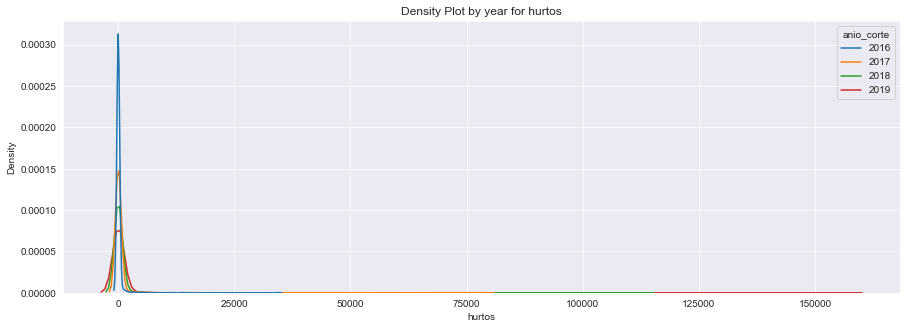

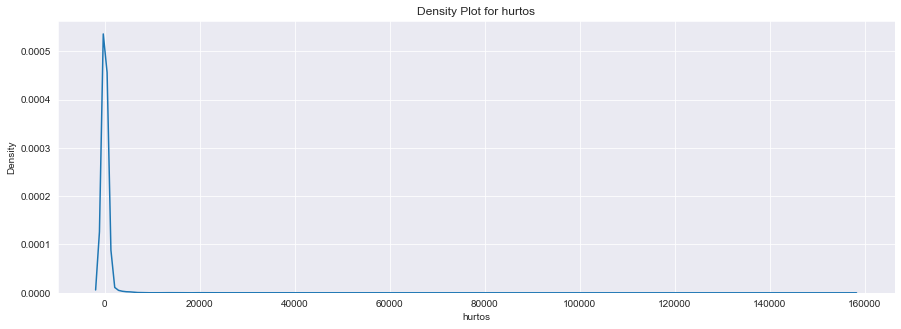

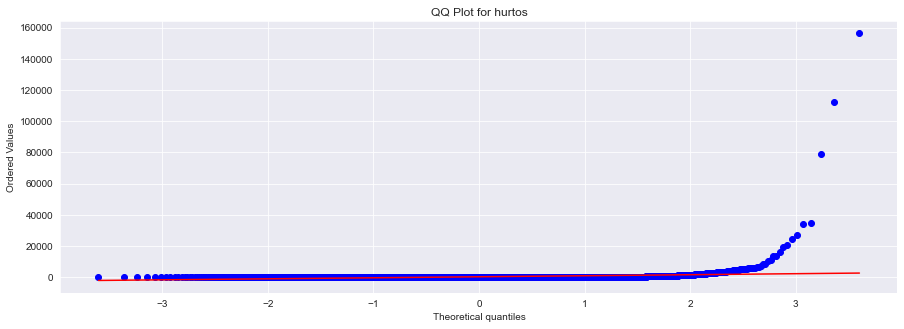

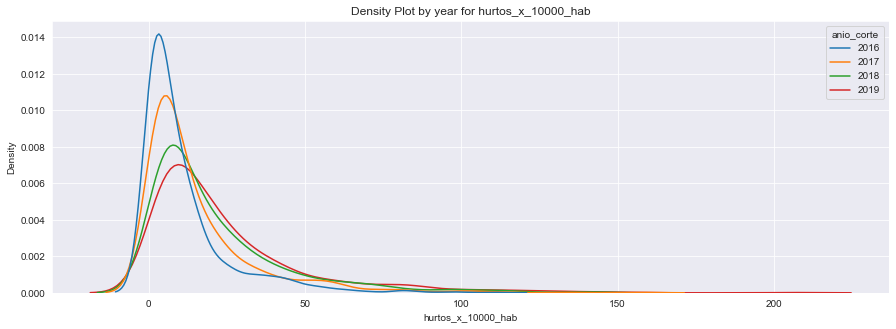

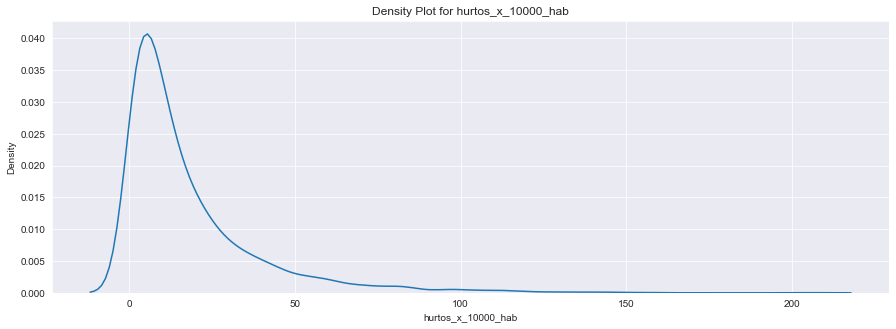

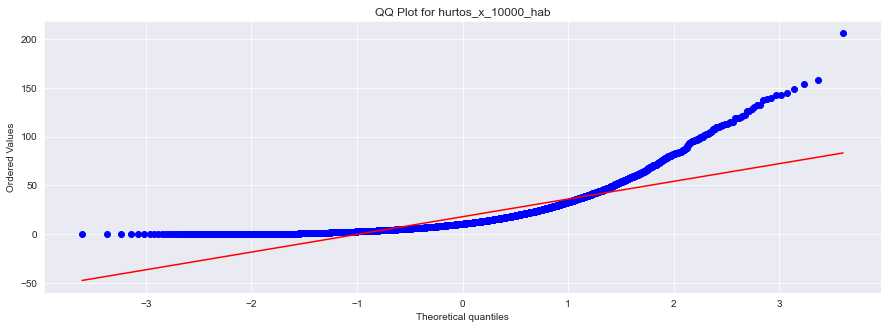

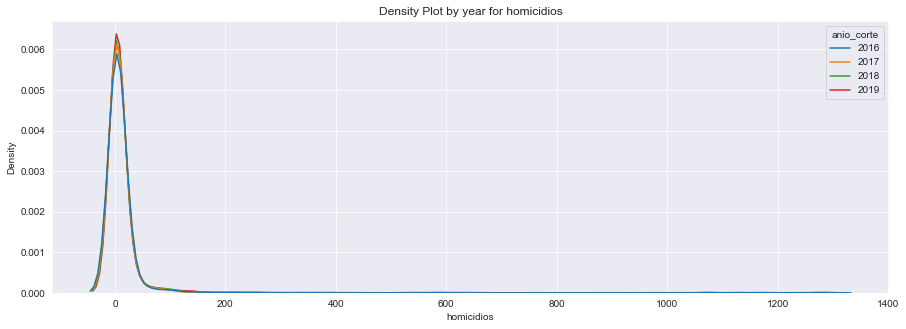

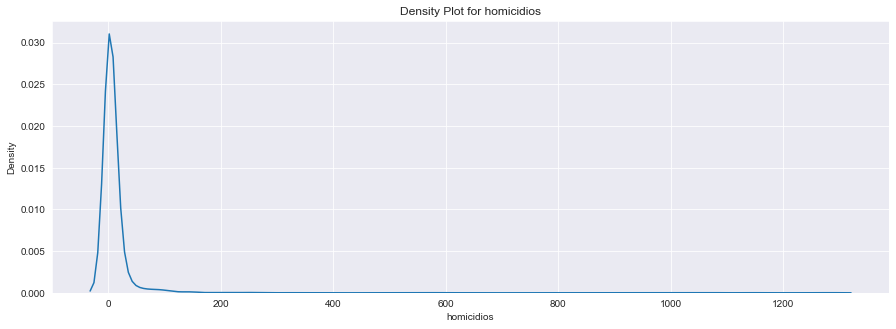

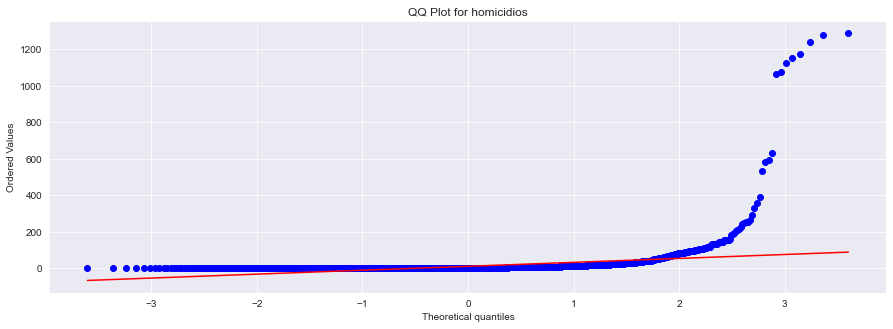

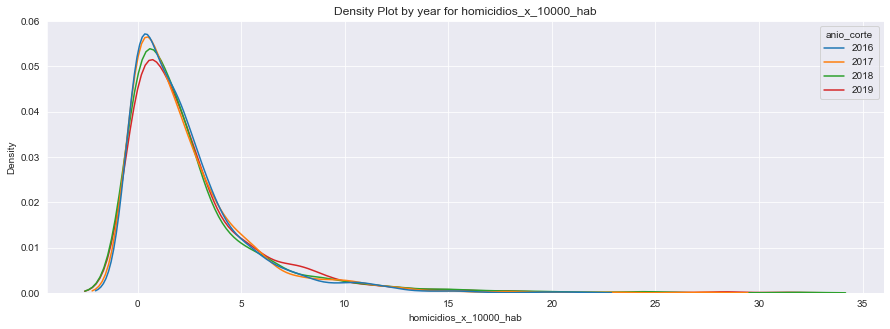

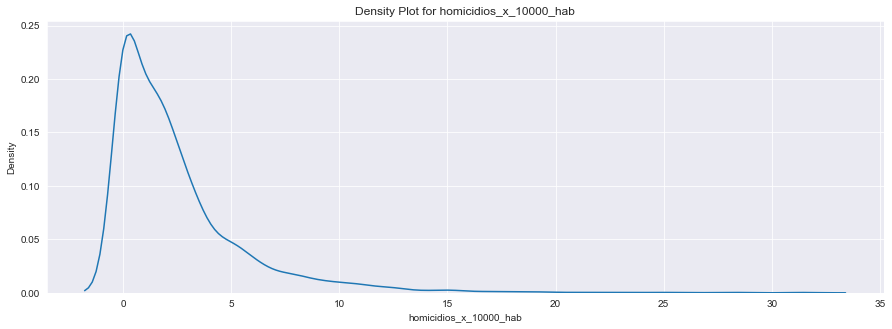

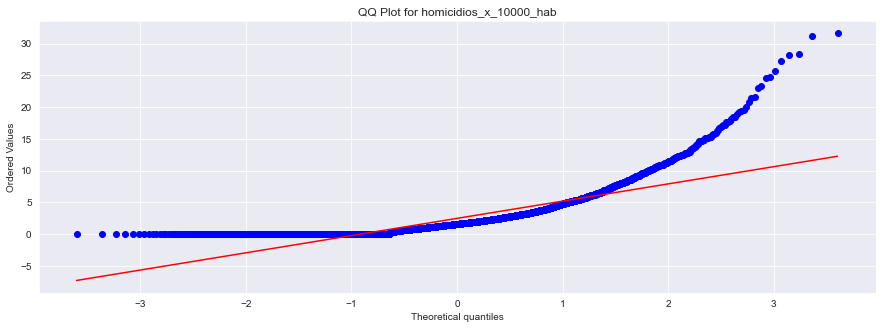

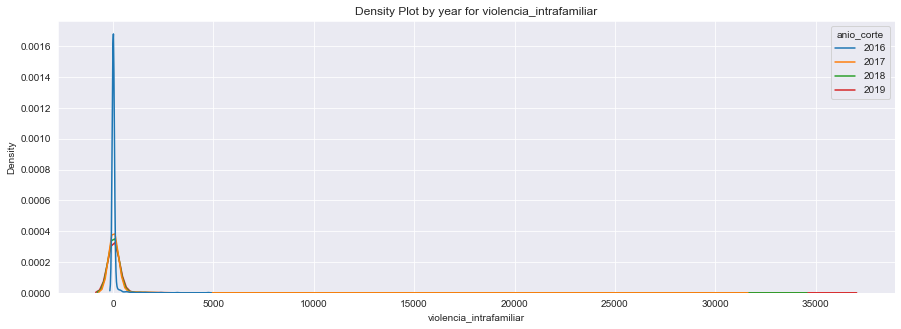

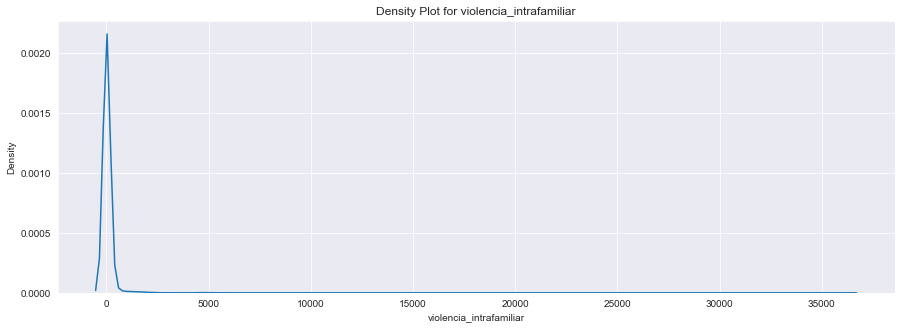

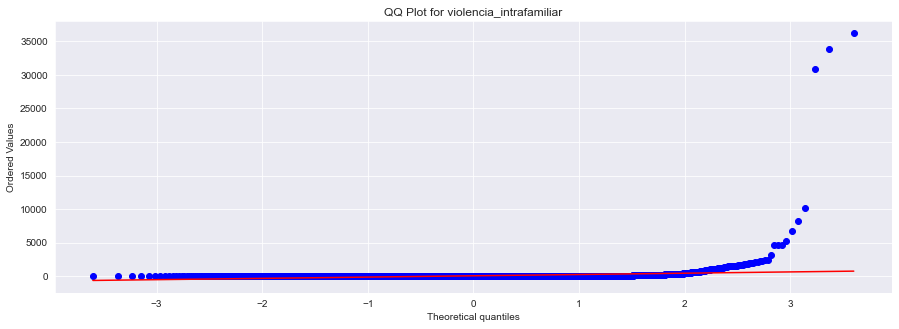

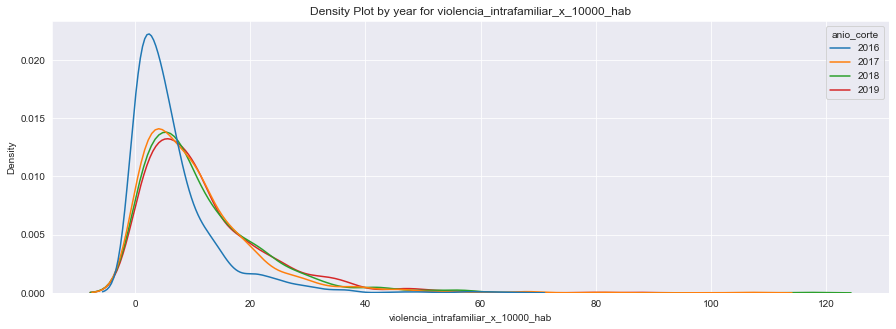

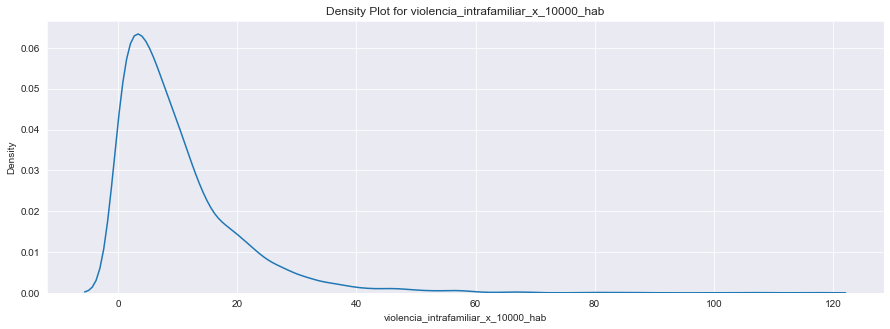

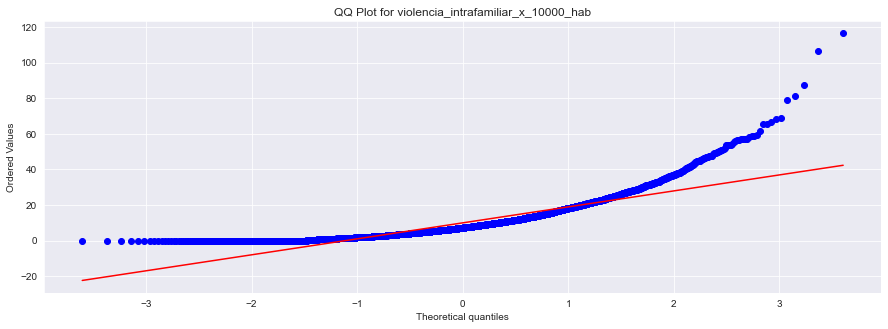

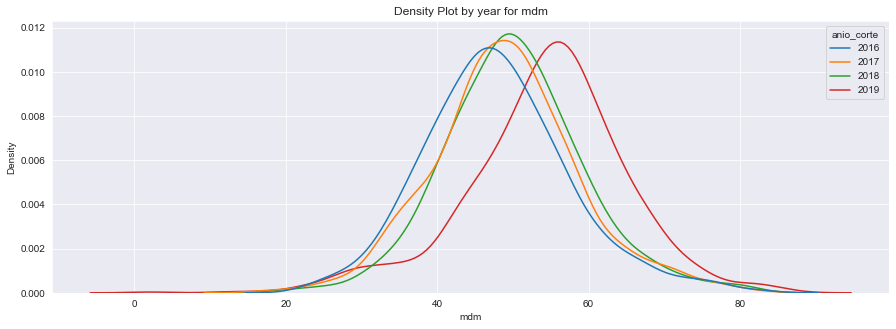

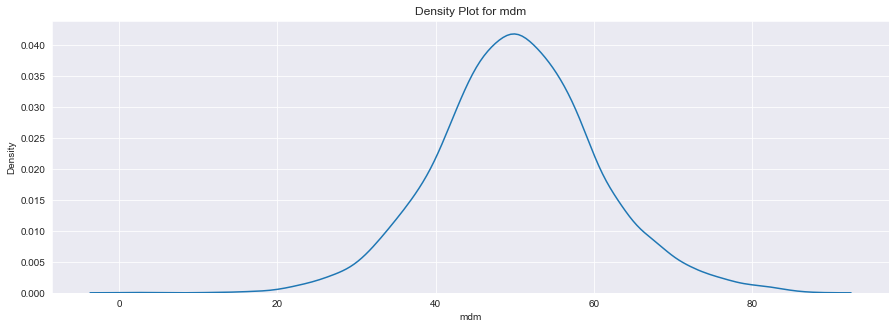

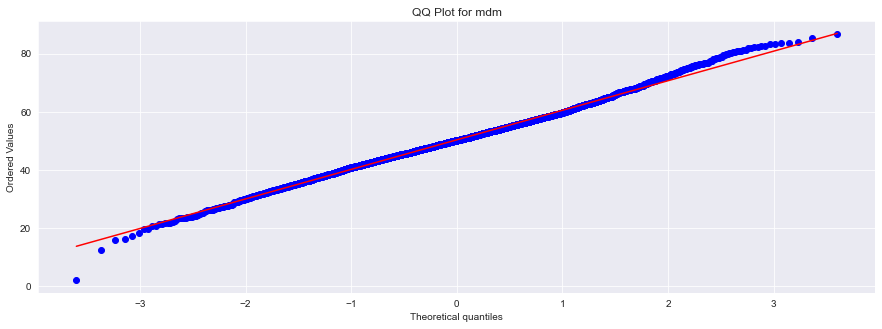

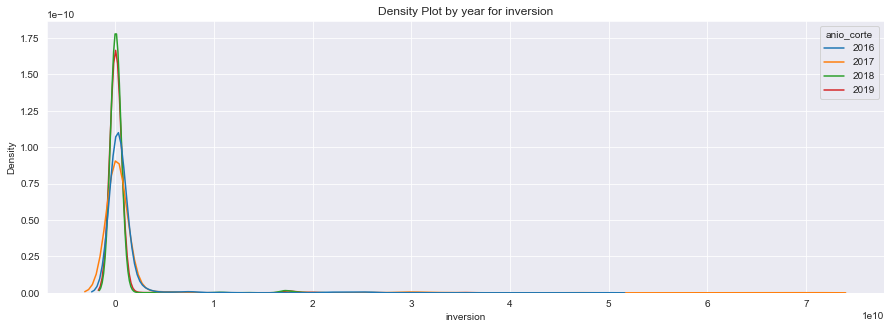

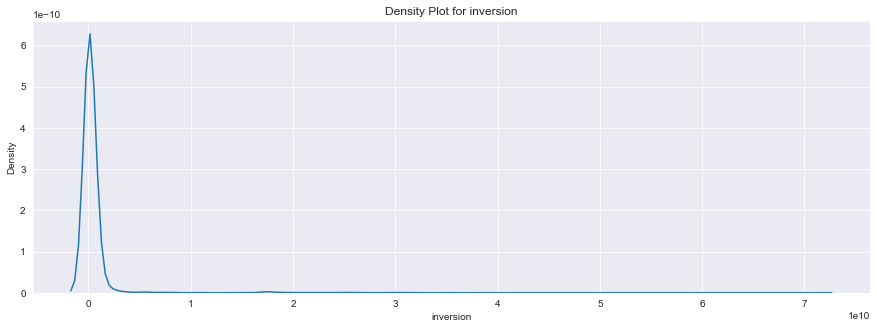

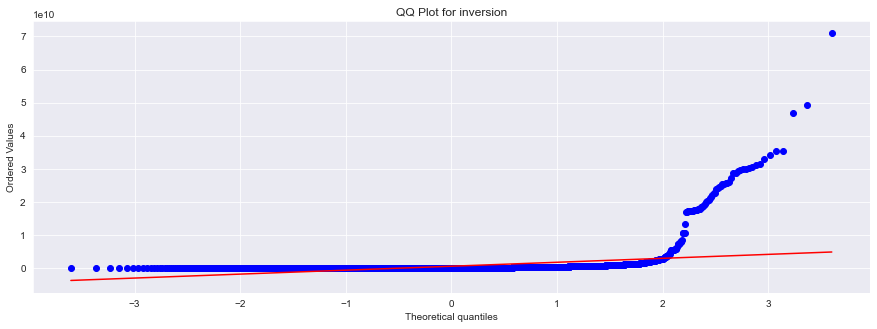

In [60]:
for col in num_cols:
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.kdeplot(x = col, hue = 'anio_corte', data = merge3)
    plt.title(f'Density Plot by year for {col}')
    plt.show()
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.kdeplot(x = col, data = merge3)
    plt.title(f'Density Plot for {col}')
    plt.show()
    fig, ax = plt.subplots(figsize=(15, 5))
    stats.probplot(x = merge3[col], dist="norm", plot = plt)
    plt.title(f'QQ Plot for {col}')
    plt.show()

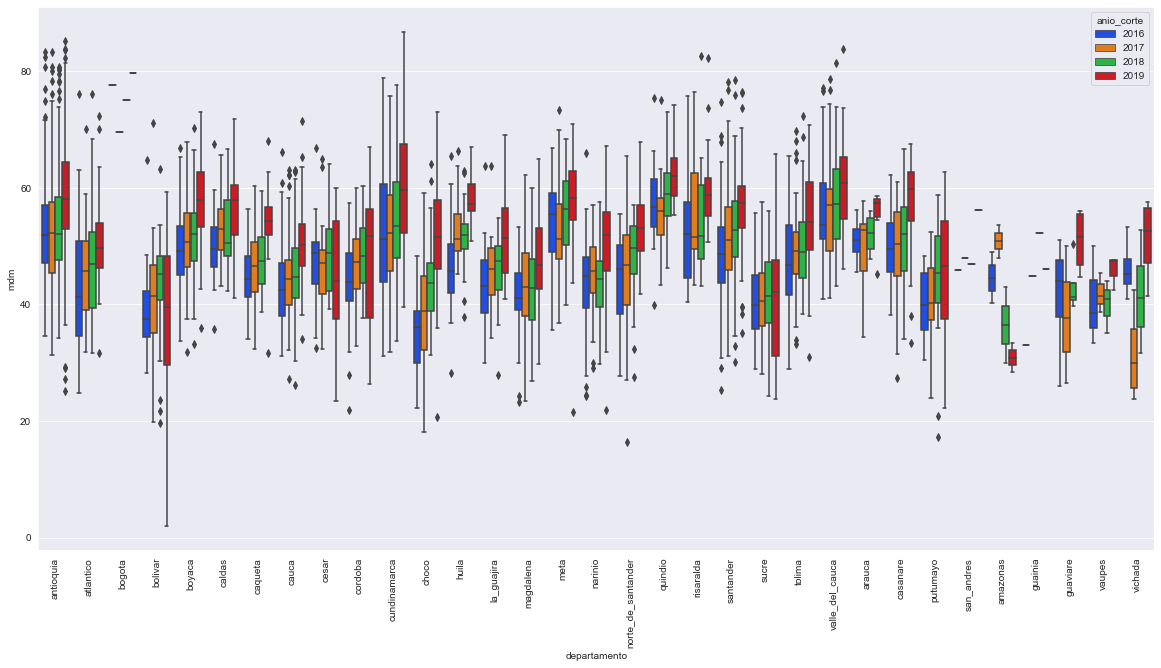

In [37]:
fig, ax = plt.subplots(figsize=(20, 10))
chart = sns.boxplot(y = 'mdm', x = 'departamento', ax = ax, hue = 'anio_corte', palette = 'bright', data = merge3)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

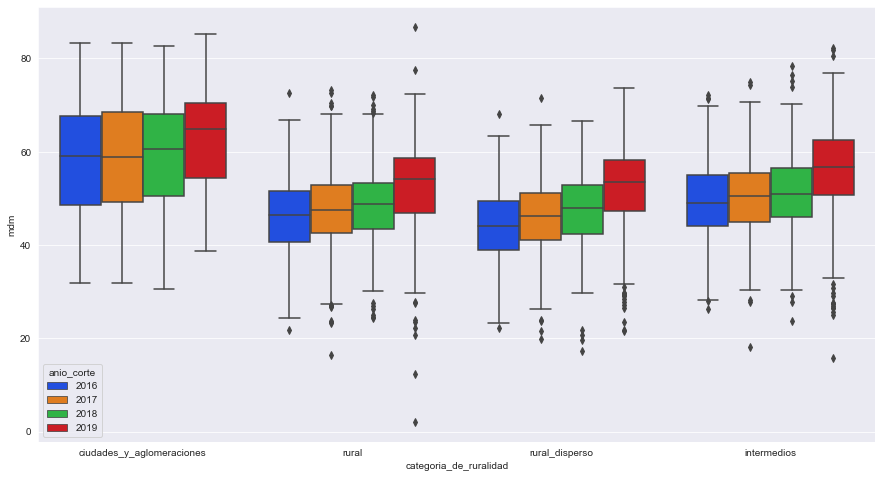

In [39]:
fig, ax = plt.subplots(figsize=(15, 8))
chart = sns.boxplot(y = 'mdm', x = 'categoria_de_ruralidad', ax = ax, hue = 'anio_corte', palette = 'bright', data = merge3)
chart.set_xticklabels(chart.get_xticklabels(), rotation=0)
plt.show()

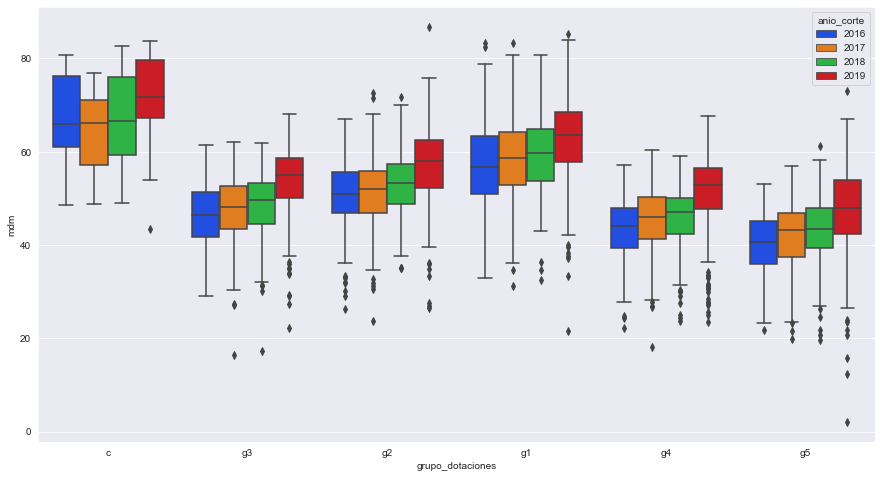

In [40]:
fig, ax = plt.subplots(figsize=(15, 8))
chart = sns.boxplot(y = 'mdm', x = 'grupo_dotaciones', ax = ax, hue = 'anio_corte', palette = 'bright', data = merge3)
chart.set_xticklabels(chart.get_xticklabels(), rotation=0)
plt.show()

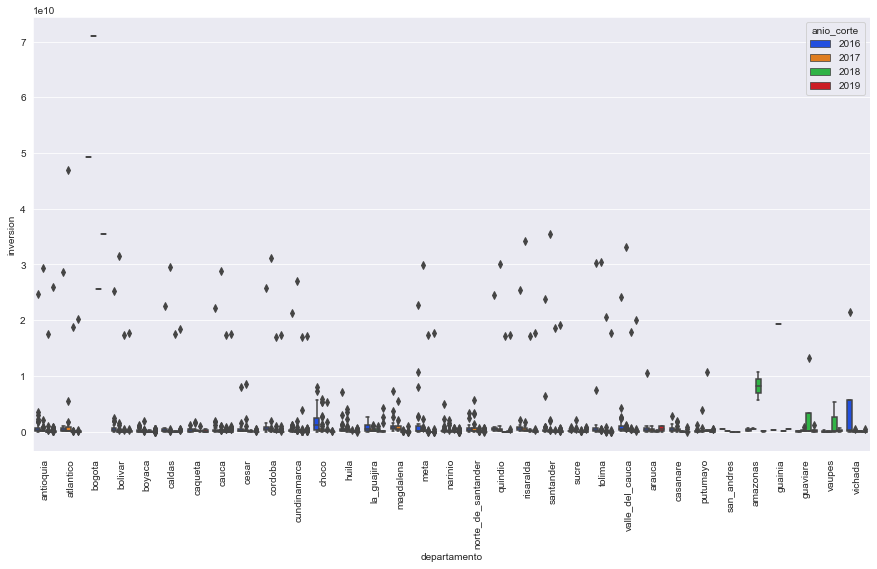

In [41]:
fig, ax = plt.subplots(figsize=(15, 8))
chart = sns.boxplot(y = 'inversion', x = 'departamento', ax = ax, hue = 'anio_corte', palette = 'bright', data = merge3)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()